# Evaluation - different training percentages overview

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from pycm import ConfusionMatrix

## Load test predictions

In [2]:
# Load training history
baseline_history = np.load("../results/baseline_(resnet15)_training_history.npy", allow_pickle=True)
train_10_history = np.load("../results/(resnet-6-block-train10)_training_history.npy", allow_pickle=True)
train_20_history = np.load("../results/(resnet-6-block-train20)_training_history.npy", allow_pickle=True)
train_40_history = np.load("../results/(resnet-6-block-train40)_training_history.npy", allow_pickle=True)
train_60_history = np.load("../results/(resnet-6-block-train60)_training_history.npy", allow_pickle=True)

# Load test predictions
baseline_predictions = np.load("../results/baseline_(resnet15)_predictions.npy")
train_10_predictions = np.load("../results/(resnet-6-block-train10)_predictions.npy")
train_20_predictions = np.load("../results/(resnet-6-block-train20)_predictions.npy")
train_40_predictions = np.load("../results/(resnet-6-block-train40)_predictions.npy")
train_60_predictions = np.load("../results/(resnet-6-block-train60)_predictions.npy")

# Load test labels
labels = np.load("../results/baseline_(resnet15)_test_labels.npy")

# Load one-hot-mapping
one_hot_mapping = np.load("one_hot_mapping.npy", allow_pickle=True)

## Training run comparison

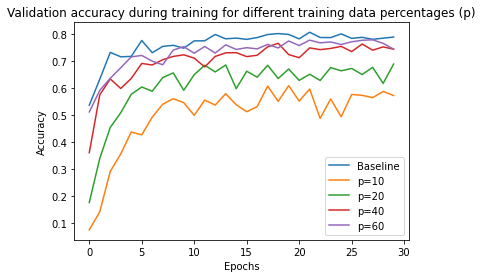

In [3]:
plt.plot(baseline_history.item().get("val_accuracy"), label="Baseline")
plt.plot(train_10_history.item().get("val_accuracy"), label="p=10")
plt.plot(train_20_history.item().get("val_accuracy"), label="p=20")
plt.plot(train_40_history.item().get("val_accuracy"), label="p=40")
plt.plot(train_60_history.item().get("val_accuracy"), label="p=60")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation accuracy during training for different training data percentages (p)")
plt.legend()
plt.show()

In [7]:
# Save validation accuracies for Latex plot
d = {'epochs': list(range(1,31)), 
     'baseline': baseline_history.item().get("val_accuracy"), 
     'train_10': train_10_history.item().get("val_accuracy"),
     'train_20': train_20_history.item().get("val_accuracy"),
     'train_40': train_40_history.item().get("val_accuracy"),
     'train_60': train_60_history.item().get("val_accuracy")}

df = pd.DataFrame(data=d)
df.to_csv('../img_data/train_per_exp_res.csv', index=False)

## FAR - FRR results

I used [this tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) to construct the ROC curve.

In [4]:
def compute_roc_curve(test_labels, test_predictions):
    far = dict()
    frr = dict()
    n_classes = 35

    # Compute fpr and tpr for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_predictions[:, i])
        fnr = 1 - tpr

        # store results
        frr[i] = fnr
        far[i] = fpr

    # First aggregate all false alarm rates
    all_far = np.unique(np.concatenate([far[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_frr = np.zeros_like(all_far)
    for i in range(n_classes):
        mean_frr += np.interp(all_far, far[i], frr[i])

    # Average the false rejection rates by the number of classes
    mean_frr /= n_classes

    far["macro"] = all_far
    frr["macro"] = mean_frr
    
    return far, frr
    
far_baseline, frr_baseline = compute_roc_curve(labels, baseline_predictions)
far_10, frr_10 = compute_roc_curve(labels, train_10_predictions)
far_20, frr_20 = compute_roc_curve(labels, train_20_predictions)
far_40, frr_40 = compute_roc_curve(labels, train_40_predictions)
far_60, frr_60 = compute_roc_curve(labels, train_60_predictions)

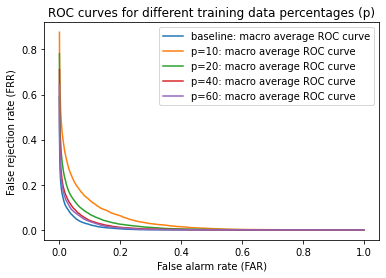

In [5]:
# Show the ROC curve
plt.plot(far_baseline['macro'], frr_baseline['macro'], label=f"baseline: macro average ROC curve")
plt.plot(far_10['macro'], frr_10['macro'], label=f"p=10: macro average ROC curve")
plt.plot(far_20['macro'], frr_20['macro'], label=f"p=20: macro average ROC curve")
plt.plot(far_40['macro'], frr_40['macro'], label=f"p=40: macro average ROC curve")
plt.plot(far_60['macro'], frr_60['macro'], label=f"p=60: macro average ROC curve")
plt.xlabel("False alarm rate (FAR)")
plt.ylabel("False rejection rate (FRR)")
plt.title("ROC curves for different training data percentages (p)")
plt.legend()
plt.show()